A new notebook to combine code needed  to :
    a) reproduce Fig.2 from Kozlowski 2017  with exactly the same setup 
    b) test  how it looks when  using a different method to find tau (expectation)
    c) compare to Chelsea's results (which light curves did she fit?)

Next: 
    * retrace the setup of Kozlowski+2017 Fig.2 
    * find what was the setup for LCs that we sent to Chelsea for fitting 
    * find the code for all 

In [1]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_dr7_quasar
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

**a)** Simulate 100 light curves per $\tau$, with 100 values of $\tau$, given $t_{exp} = 8$ years, $SF_{\infty}=0.2$, select either N=60 or N=445 points  ( number of points sets $\Delta t$), sampling of SDSS QSO, or random for OGLE. Fit with the adaptative grid method, 60x60

In [34]:
# Simulate 10'000 light curves

def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).
       
       Note:  sampling times t  must be a sorted array ! 
    '''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag



### Reproduce SDSS and OGLE sampling (8 year light curve,  N=60 or 445)

** run this only once, then it is saved ...  **

In [5]:
# this has only names of QSOs...
#sdss_qso = fetch_dr7_quasar()

# the light curves are here 
# The S82 QSO light curves 
# http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html

# grab SDSS sampling from a random light curve ...
sdss = Table.read('../raw_data/SDSS_QSO/1000679', format='ascii')
sdss_times = sdss['col1'][1:]
sdss_times = sdss_times - min(sdss_times) # start from 0 

 # add to the end of the light curve the same 
t = np.array(sdss_times) 
t = np.append(t, t[-1]+t[1:])

# select points up to 8 years 
m = t/365 < 8.5 
fig,ax = plt.subplots(2,1,figsize=(8,8))
for l in t[m]:
    ax[0].axvline(l/365)
ax[0].set_title('SDSS Original, N='+ str(len(t[m])))
# choose 60 random points from that light curve
# selecting 60 indices 
random_indices=  np.random.randint(low=0, high=len(t[m]), size=60)

# sort by time 
t60 = np.sort(t[m][random_indices])
for l in t60:
    ax[1].axvline(l/365)
ax[1].set_title('SDSS Downsampled, N='+ str(len(t60)))
ax[1].set_xlabel('years')

# try to reproduce OGLE sampling by simply taking 
# random samples from a uniform distribution
t445 = np.sort(np.random.randint(low=0, high=8*365, size=445))
fig,ax = plt.subplots(1,1,figsize=(8,4))
for l in t445 : 
    ax.axvline(l/365.)
ax.set_title('OGLE N=445, 8 years, random sampling')

# Since I am using random indices in both cases,
# store them given that I sample all light curves at
# these times !!!
np.savetxt('t_OGLE.txt', t445)
np.savetxt('t_SDSS.txt', t60)

### Simulate two sets of light curves 

For SDSS, we use the sampling above:  8 years, with N=60 points. For OGLE we use 8 years, N=445, random sampling. We use the same sampling 10 000 times, with 100 light curves simulated per input $\tau$, over 100 values of $\tau$ between :

In [32]:
t_exp = 8 * 365 # days 
rho_in = np.array([0.001, 15])
tau_in = rho_in * t_exp
print(' %.2f < tau_in < %.2f  [days]'% (tau_in[0], tau_in[1]))

 2.92 < tau_in < 43800.00  [days]


Thus we have two sets of 10 000 light curves for fitting. 

Note : we store "true" underlying DRW, i.e. no noise. This is added later, just before the simulaiton. 

In [48]:
plot = False
SF_inf = 0.2 # mag 
t_exp = 8 * 365.0 # in days 
rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)

for simulation in ['OGLE', 'SDSS'] : 
    if simulation is 'SDSS' : 
        t = np.loadtxt('t_SDSS.txt')
    if simulation is 'OGLE':
        t = np.loadtxt('t_OGLE.txt')
    outDir = '../data_products/Simulated_DRW_Kozlowski/'+simulation+'/'
    print(simulation)
    
    for i,rho_in in enumerate(rho_grid) : 
        tau_in = rho_in * t_exp
        if i % 10 == 0 : 
            print(i)
        # for each rho, simulate 100 light curves 
        for j in range(100):
            y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)
            name = 'DRW_rho-' + str(i).zfill(3)+'_'+str(j).zfill(3)+'.txt'
            np.savetxt(outDir+name,y, fmt = ' %.5f ')
print('Done')

OGLE
0
10
20
30
40
50
60
70
80
90
SDSS
0
10
20
30
40
50
60
70
80
90


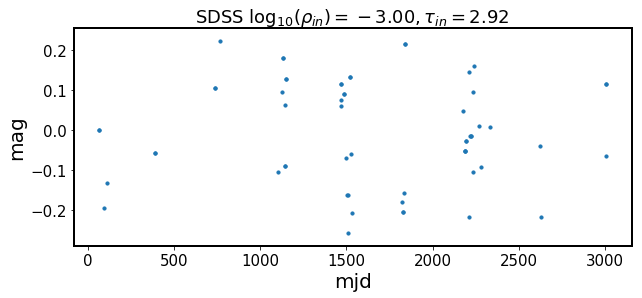

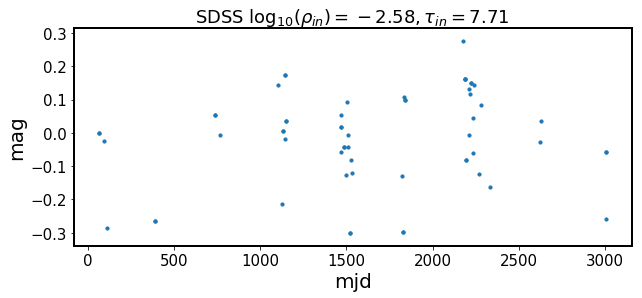

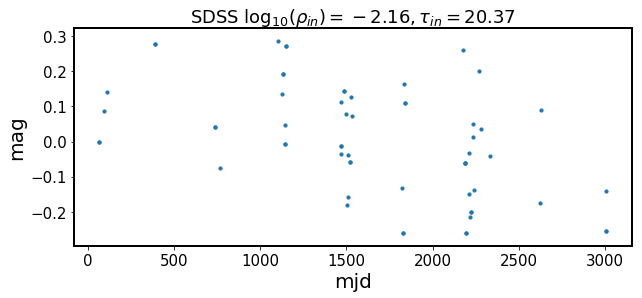

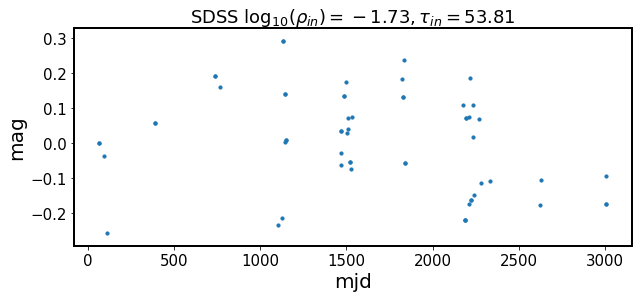

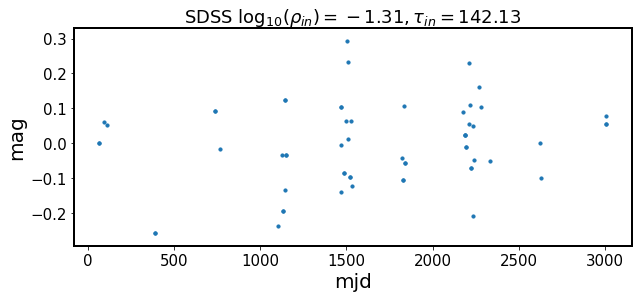

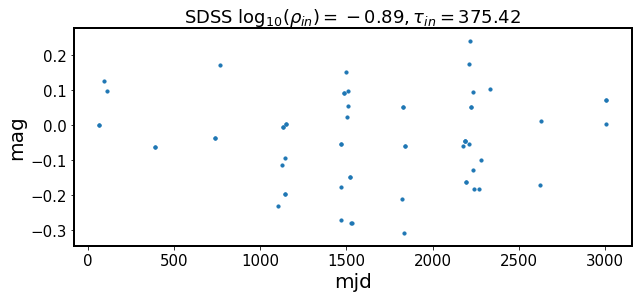

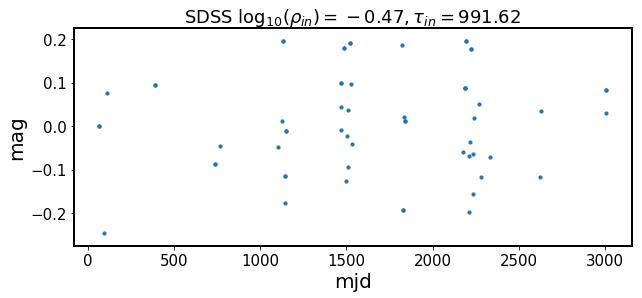

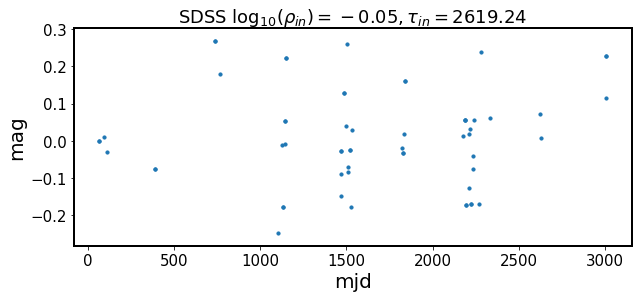

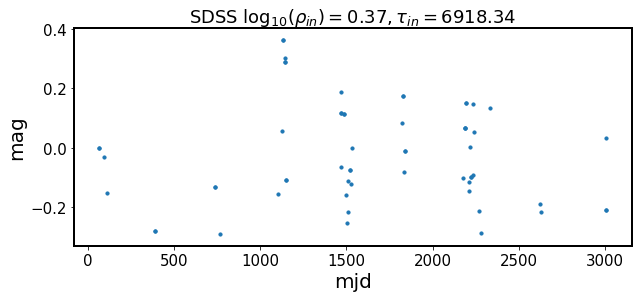

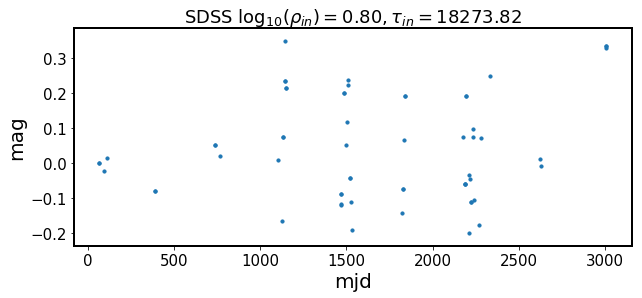

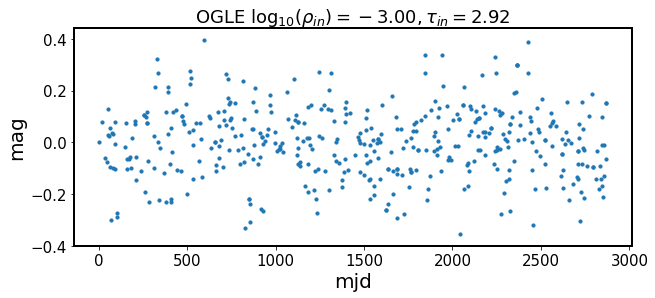

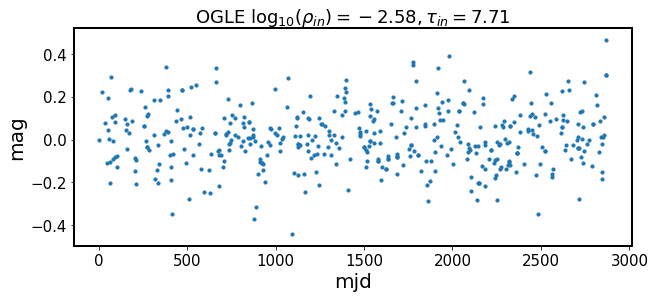

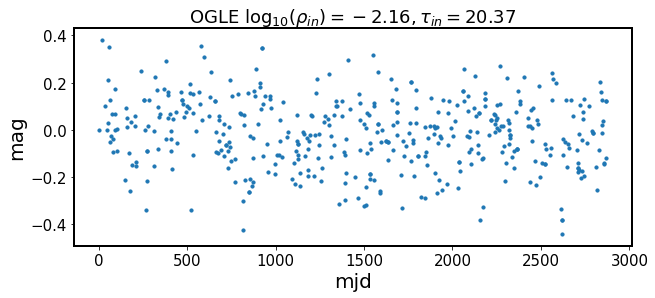

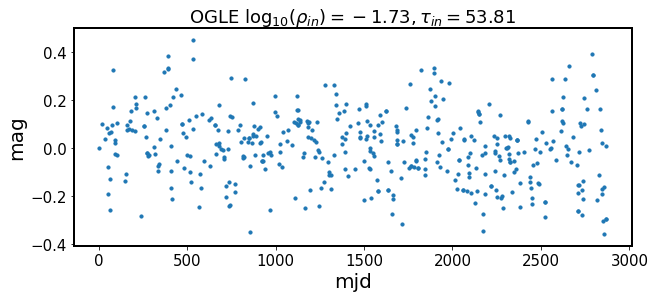

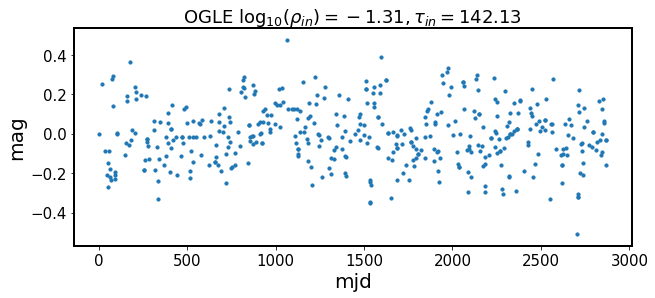

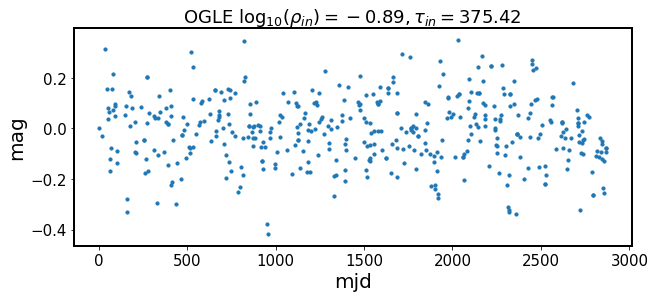

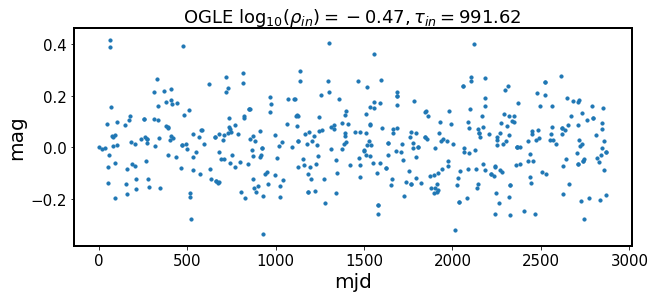

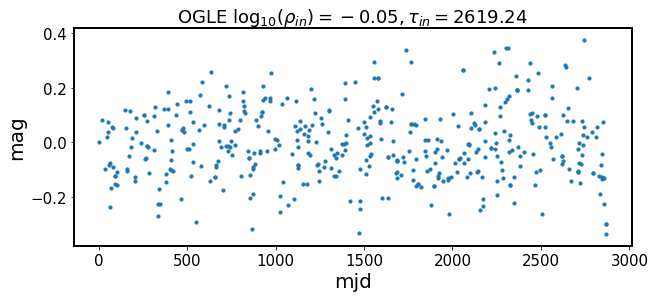

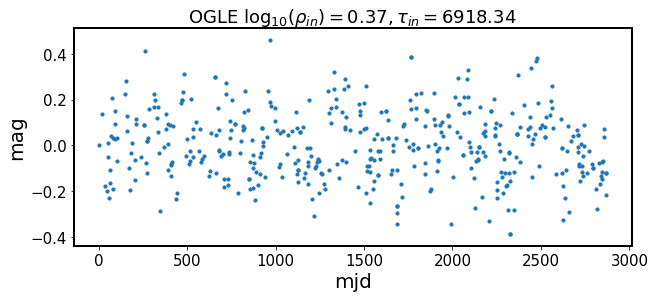

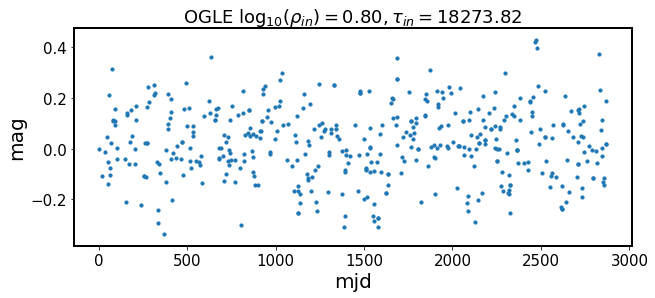

In [49]:
# Plot an example light curve for each value of rho, for SDSS and OGLE...
%matplotlib inline
figDir = '../data_products/Simulated_DRW_Kozlowski/Fig_example_LC/'

for simulation in ['SDSS', 'OGLE'] : 
    if simulation is 'SDSS' : 
        t = np.loadtxt('t_SDSS.txt')
    if simulation is 'OGLE':
        t = np.loadtxt('t_OGLE.txt') 
        
    outDir = '../data_products/Simulated_DRW_Kozlowski/'+simulation+'/'
    # show only every tenth element of the rho_grid... 
    for i,rho_in in enumerate(rho_grid[::10]) : 
        j = 0
        name = 'DRW_rho-' + str(i).zfill(3)+'_'+str(j).zfill(3)+'.txt'
        y = np.loadtxt(outDir+name)
        fig,ax = plt.subplots(1,1,figsize=(10,4))
        tau_in = rho_in * t_exp
        ax.set_title(simulation+' '+\
                     r'$\log_{10}{(\rho_{in})}=%.2f, \tau_{in}=%.2f$'%(np.log10(rho_in),
                                                                       tau_in))
        ax.scatter(t,y,s=10)
        ax.set_xlabel('mjd')
        ax.set_ylabel('mag')
        plt.savefig(outDir + simulation+'_rho-'+str(i)+'.png', bbox_inches='tight')
        plt.show()


### Fitting the light curves: MAP with Jeff2, adaptative grid with Jeff1 (60x60)

Fit the light curves with Celerite , using either the maximum of log-posterior (with scipy.optimize.minimize, which mimics the method that Kozlowski used to obtain the fit), or the expectation value of sigma,tau evaluated on a coarse grid (65x65). For both I will employ modest limits  $\sigma \in [0.02, 0.7]$, $\tau \in [5,2000]$ 


May also send the light curves to Chelsea to get her fits too.... Or try running her code on this computer - perhaps I'd have better luck with getting FORTRAN run this time ! 



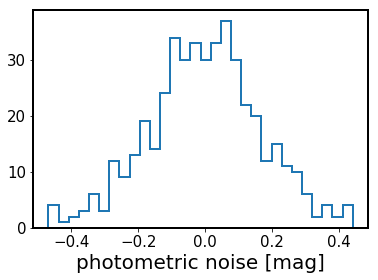

In [163]:
# Illustrate the Gaussian noise added to OGLE ...
loc=0; var = 0.0248445133097
noise  = np.random.normal(loc=loc,scale=np.sqrt(var),size=445)
plt.hist(noise, histtype='step',lw=2, bins=30)
plt.xlabel('photometric noise [mag]')

In [4]:
# functions for adaptative gridding .... 
def calculate_log_posterior(prior, params,y,gp):
    if prior is 'flat' : 
        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)

    if prior is 'p1' : # sigma*tau 
        def neg_log_like(params,y,gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
            return -gp.log_likelihood(y) - (log_a / 2.0) + log_c

    if prior is 'p2' : # sigma_hat * tau 
         def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
            return -gp.log_likelihood(y)  +0.5* (-np.log(2) + log_c - log_a  )

    if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
        def neg_log_like(params,y,gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
            # - log_likelihood - log(prior)
            log_prior = - (log_a / 2.0) + log_c
            return -gp.log_likelihood(y, quiet=True) - log_prior
    
    if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
             # - log_likelihood - log(prior)
            log_prior  = 0.5* (-np.log(2.0) - log_a + log_c  )
            return -gp.log_likelihood(y, quiet=True)  - log_prior
        
    return -neg_log_like(params, y, gp)

In [2]:


def find_new_limits(grid, logP, param = 'sigma', threshold=0.1 ,
                    verbose=True):
    dx = grid[1] - grid[0]
    if param is 'tau':
        p_x = np.exp(logP).sum(0)
    if param is 'sigma':
        p_x = np.exp(logP).sum(1)
    p_x /= p_x.sum() * (dx)  # this ensures probability adds up to 1 
    p_x /= max(p_x)  # this ensures that max prob is 1 

    min_idx = np.where(p_x > threshold)[0][0]  
    max_idx = np.where(p_x > threshold)[0][-1]
    print(min_idx, max_idx, grid[min_idx], grid[max_idx])
    
    # case where the beginning of grid is the beginning of peak.... 
    if max_idx == 0 : 
        if param is 'tau':
            new_min = 1 
            new_max = 0.2 * grid[1]
            
        if param is 'sigma':
            new_min = 0.1 * min(grid)
            new_max = grid[1]
            
        if verbose:
            print('max_idx = 0')

    # case where the peak is really close to the  
    # initial beginning of the grid ... 
    # need to lower the grid limit below the initial value ... 
    elif ( (min_idx >= 0) * (min_idx < 5) * ((max_idx) <= len(grid)) ): 
        new_min = 0.5 * min(grid)
        new_max = grid[max_idx]
        if verbose:
            print('peak very close to the grid minimum')

    # case where the peak is well contained within
    # the actual grid
    elif (min_idx >= 5) * ((max_idx+5) <= len(grid)):
        new_min = grid[min_idx-2]
        new_max = grid[max_idx+2]
        if verbose:
            print('peak contained in the grid ')

    # case where the beginning is well contained, 
    # and the end is less than 5 units away
    # from the edge 
    elif (min_idx >= 5) *((min_idx +5)<= len(grid)) * ((max_idx+5) > len(grid)):
        new_min = grid[min_idx-2]
        new_max = grid[max_idx]
        if verbose:
            print('peak end close to the edge of the  grid ')
    # case where the beginnig of the peak 
    # is close to the end of the grid 
    # we need to move the minimum closer to the end 
    # and extend the maximum...
    elif (min_idx + 5) > len(grid) : 
        new_min = grid[min_idx-2]
        new_max = 1.5 * max(grid)
        if verbose:
            print('peak close to the grid maximum ')
            

    new_limits = [new_min, new_max]
    
    print('New ',param,' limits are: ', new_limits)
    
    return new_limits


In [5]:
import numdifftools as nd

# initialize the Celerite kernel : 
# same for all light curves ... 
sigma0 = 0.2
tau0 = 100
kernel = terms.RealTerm(log_a = 2 * np.log(sigma0) , 
                        log_c = np.log(1.0/tau0))
SF_inf = 0.2 # mag 
t_exp = 8 * 365.0 # in days 
rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)

for simulation in ['SDSS','OGLE']:
    if simulation is 'SDSS' : 
        r = 17 # mag 
        variance = 0.013**2.0 + np.exp(2 * (r-23.36))
        t = np.loadtxt('t_SDSS.txt')
    if simulation is 'OGLE' : 
        I = 18 # mag 
        variance = 0.004**2.0 + np.exp(1.63 * (I - 22.55))    
        t =  np.loadtxt('t_OGLE.txt')
        
    print(simulation,' noise stdev ', np.sqrt(variance))
    
    # set the light curve directory 
    outDir = '../data_products/Simulated_DRW_Kozlowski/'+simulation+'/'
    
    # set the output directory 
    resDir  = '../data_products/Simulated_DRW_Kozlowski/'+simulation+'/new_results/'
    
    # read in the light curves
    for i in range(len(rho_grid)): 
        rho_in = rho_grid[i]
        tau_in = rho_in * t_exp
        if i % 10 == 0 : 
            print(i)
        # for each rho, simulate 100 light curves 
        for j in range(10):#range(100):
            fname = 'DRW_rho-' + str(i).zfill(3)+'_'+str(j).zfill(3)+'.txt'
            y = np.loadtxt(outDir+fname)
            # make a random draw from a Gaussian distribution
            # centered on 0,
            # with variance set by the equation from Kozlowski+2017
            # variance is different for OGLE or  SDSS 
            noise = np.random.normal(loc=0,scale=np.sqrt(variance),size=len(t))
            y += noise +10 # eq.2 Kozlowski+2017
            
            # the uncertainty on each measurement : 
            # I set it to sigma_SDSS = 0.0248, or sigma_OGLE = 0.0131,
            # homoscedastic, i.e. same errors for all points 
            yerr = np.ones_like(t)* np.sqrt(variance)
            
            # fit with Celerite using adaptative grid, or MAP 
            # using Jeff1 prior or Jeff2 prior.... 

            # define which priors we would like to try ... 
            priors = ['Jeff1','Jeff2'] # ['flat', 'p1', 'p2', 'Jeff1', 'Jeff2']

            # call the model  with a chosen kernel instance 
            gp = celerite.GP(kernel, mean=np.mean(y))
            gp.compute(t, yerr)
            
            # set initial params 
            initial_params = gp.get_parameter_vector()
             
            # set boundaries for Celerite 
            sig_lims = [0.02, 0.7]  ; tau_lims = [1,10000]
            tau_bounds, sigma_bounds = tau_lims, sig_lims
            logc_bounds= (np.log(1/max(tau_bounds)), 
                          np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 
                           2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]
                
            # store the resulting logPosterior spaces 
            # as a dictionary : results['Jeff1','Jeff2']:  ['logPosterior',
            # 'sigmaGrid', 'tauGrid', 'sigmaMAP', 'tauMAP'
            # ]
            print('tau_in = ', tau_in)
            results = {}
            for prior in priors: 
                results[prior] = {}
                # starting grid : for each LC we need to start it anew...
                N = 60 
                #sig_lims = [0.02, 0.7] ; tau_lims = [1,10000]
                sigma_grid = np.linspace(sig_lims[0], sig_lims[1],N )
                tau_grid  = np.linspace(tau_lims[0], tau_lims[1], N)
                log_a_grid = 2 * np.log(sigma_grid)
                log_c_grid = np.log(1/tau_grid)

                # loop over the likelihood space .... 
                logPosterior = np.zeros([N,N], dtype=float)
                for k in range(len(log_a_grid)):
                    for l in range(len(log_c_grid)):
                        params = [log_a_grid[k],log_c_grid[l]]    
                        logPosterior[k,l] = calculate_log_posterior(prior, params,y,gp)
                        
                if np.sum(np.isinf(logPosterior)) < 0.9 * len(np.ravel(logPosterior)) : 
                    
                    # find the place where marginalized distributions 
                    # for sigma, tau start increasing above eg. 1% 
                    sig_lims_new = find_new_limits(sigma_grid, logPosterior,
                                                   param = 'sigma',)
                    tau_lims_new = find_new_limits(tau_grid, logPosterior, 
                                                   param = 'tau',)
                    #  make a new grid 
                    N= 60
                    sigma_grid = np.linspace(sig_lims_new[0], sig_lims_new[1], N )
                    tau_grid  = np.linspace(tau_lims_new[0], tau_lims_new[1], N)
                    log_a_grid = 2 * np.log(sigma_grid)
                    log_c_grid = np.log(1/tau_grid)

                    logPosterior = np.zeros([N,N], dtype=float)
                    for k in range(len(log_a_grid)):
                        for l in range(len(log_c_grid)):
                            params = [log_a_grid[k],log_c_grid[l]]    
                            logPosterior[k,l] = calculate_log_posterior(prior, 
                                                        params,y,gp)
                else:
                    print('Cant do adaptative grid, > 90% of logL is infinite')
                    #logPosterior = 
                # store the logPosterior, as well as sigma, tau grid 
                # as a dictionary ...
                results[prior]['logPosterior'] = logPosterior
                results[prior]['sigma_grid'] = sigma_grid
                results[prior]['tau_grid'] = tau_grid

                # Celerite MAP : use scipy optimize minimize 
                # find the maximum of the log posterior 
                # (minimum of negative log posterior) 

                if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
                    def neg_log_like(params,y,gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        # - log_likelihood - log(prior)
                        return -gp.log_likelihood(y) -(-(log_a / 2.0) + log_c )

                if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
                    def neg_log_like(params, y, gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                         # - log_likelihood - log(prior)
                        return -gp.log_likelihood(y)  - (0.5* (-np.log(2) - log_a + log_c  ))

                r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
                gp.set_parameter_vector(r.x)

                # retrieve the best-fit parameters 
                res = gp.get_parameter_dict()
                sigmaMAP = np.exp(res['kernel:log_a']/2)
                tauMAP = 1.0 / np.exp(res['kernel:log_c'])

                # Calculate error on the estimate of sigma, mu
                def Wrap_neg_log_like(theta) : 
                    return neg_log_like(theta, y,gp)

                Hfun = nd.Hessian(Wrap_neg_log_like, full_output=True)
                hessian_ndt, info = Hfun(r['x'])

                # standard deviation is the square of variance
                se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))

                # error from hessian on log_a, log_c
                s_sigma = se[0]
                s_tau = se[1]
                
                # store the logPosterior, as well as sigma, tau grid 
                # as a dictionary ...
                results[prior]['logPosterior'] = logPosterior
                results[prior]['sigma_grid'] = sigma_grid
                results[prior]['tau_grid'] = tau_grid
                results[prior]['sigma_MAP'] = sigmaMAP
                results[prior]['tau_MAP'] = tauMAP
                results[prior]['sigma_MAP_err'] = s_sigma
                results[prior]['tau_MAP_err'] = s_tau
                results[prior]['rho_in'] = rho_in
                results[prior]['tau_in'] = tau_in

            # save in  a file ...
            name = fname[:-4]+'_logP.npy'
            np.save(resDir  + name, results)
            print('Saved logP (and MAP) dic as %s'%name)

        

SDSS  noise stdev  0.0131145228363
0
tau_in =  2.92
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-000_000_logP.npy
tau_in =  2.92
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-000_001_logP.npy
tau_in =  2.92
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-000_002_logP.npy
tau_in =  2.92
9 13 0.123728813559 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


9 13 0.123728813559 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-000_003_logP.npy
tau_in =  2.92
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-000_004_logP.npy
tau_in =  2.92
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 11 0.100677966102 0.146779661017
peak contained in th

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-000_008_logP.npy
tau_in =  2.92
7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-000_009_logP.npy
tau_in =  3.21784848723
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-001_000_logP.npy
tau_in =  3.21784848723
5 8 0.0776271186441 0.112203389831
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.13525423728813557]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
5 8 0.0776271186441 0.112203389831
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.13525423728813557]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-001_001_logP.npy
tau_in =  3.21784848723
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 14 0.123728813559 0.181355932203


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-001_007_logP.npy
tau_in =  3.21784848723
11 17 0.146779661017 0.21593220339
peak contained in the grid 
New  sigma  limits are:  [0.12372881355932203, 0.23898305084745761]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
11 17 0.146779661017 0.21593220339
peak contained in the grid 
New  sigma  limits are:  [0.12372881355932203, 0.23898305084745761]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-001_008_logP.npy
tau_in =  3.21784848723
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
pea

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-002_002_logP.npy
tau_in =  3.54607838589
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-002_003_logP.npy
tau_in =  3.54607838589
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-00

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-002_005_logP.npy
tau_in =  3.54607838589
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-002_006_logP.npy
tau_in =  3.54607838589
7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-002_007_logP.npy
tau_in =  3.54607838589
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-002_008_logP.npy
tau_in =  3.54607838589
9 13 0.123728813559 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


9 13 0.123728813559 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-002_009_logP.npy
tau_in =  3.90778868824
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-003_000_logP.npy
tau_in =  3.90778868824
9 13 0.123728813559 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 13 0.123728813559 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-003_001_logP.npy
tau_in =  3.90778868824
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 12 0.100677966102 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-003_005_logP.npy
tau_in =  3.90778868824
12 18 0.158305084746 0.227457627119
peak contained in the grid 
New  sigma  limits are:  [0.13525423728813557, 0.25050847457627118]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
12 18 0.158305084746 0.227457627119
peak contained in the grid 
New  sigma  limits are:  [0.13525423728813557, 0.25050847457627118]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-003_006_logP.npy
tau_in =  3.90778868824
7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rh

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-004_001_logP.npy
tau_in =  4.30639449277
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-004_002_logP.npy
tau_in =  4.30639449277
10 16 0.135254237288 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.22745762711864403]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
10 16 0.135254237288 0.204406779661


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-004_004_logP.npy
tau_in =  4.30639449277
10 15 0.135254237288 0.192881355932
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.21593220338983046]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
10 15 0.135254237288 0.192881355932
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.21593220338983046]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-004_005_logP.npy
tau_in =  4.30639449277
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 13 0.112203389831 0.169830508475


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-005_009_logP.npy
tau_in =  5.2297302849
7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-006_000_logP.npy
tau_in =  5.2297302849
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-006_001_logP.npy
tau_in =  5.2297302849
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 13 0.112203389831 0.169830508475
pea

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-006_003_logP.npy
tau_in =  5.2297302849
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-006_004_logP.npy
tau_in =  5.2297302849
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-006_005_logP.npy
tau_in =  5.2297302849
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-006_006_logP.npy
tau_in =  5.2297302849
10 15 0.135254237288 0.192881355932
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.21593220338983046]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
10 15 0.135254237288 0.192881355932


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-006_008_logP.npy
tau_in =  5.2297302849
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-006_009_logP.npy
tau_in =  5.76317797463
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 11 0.100677966102 0.146779661017
pea

8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-008_005_logP.npy
tau_in =  6.35103887922
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-008_006_logP.npy
tau_in =  6.35103887922
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 14 0.123728813559 0.181355932203
pea

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 10 0.100677966102 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-009_004_logP.npy
tau_in =  6.99886330475
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-009_005_logP.npy
tau_in =  6.99886330475
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 11 0.100677966102 0.146779661017

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


6 10 0.0891525423729 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-010_000_logP.npy
tau_in =  7.71276770464
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-010_001_logP.npy
tau_in =  7.71276770464
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 14 0.123728813559 0.181355932203
p

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-010_005_logP.npy
tau_in =  7.71276770464
10 16 0.135254237288 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.22745762711864403]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
10 16 0.135254237288 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.22745762711864403]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-010_006_logP.npy
tau_in =  7.71276770464
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 13 0.112203389831 0.169830508475

9 13 0.123728813559 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-012_002_logP.npy
tau_in =  9.36646536055
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-012_003_logP.npy
tau_in =  9.36646536055
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 11 0.100677966102 0.146779661017
pe

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-013_002_logP.npy
tau_in =  10.3218720518
6 9 0.0891525423729 0.123728813559
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.14677966101694914]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
6 9 0.0891525423729 0.123728813559
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.14677966101694914]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-013_003_logP.npy
tau_in =  10.3218720518
6 9 0.0891525423729 0.123728813559
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.14677966101694914]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
6 9 0.0891525423729 0.123728813559

10 39 0.135254237288 0.469491525424
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.49254237288135588]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-014_009_logP.npy
tau_in =  12.5349888304
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-015_000_logP.npy
tau_in =  12.5349888304
9 14 0.123728813559 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.20440677966101692]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-015_007_logP.npy
tau_in =  12.5349888304
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-015_008_logP.npy
tau_in =  12.5349888304
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-015_009_logP.npy
tau_in =  13.8135941251
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]

8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-017_004_logP.npy
tau_in =  15.2226208763
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-017_005_logP.npy
tau_in =  15.2226208763
8 13 0.112203389831 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.19288135593220337]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 13 0.112203389831 0.169830508475


Saved logP (and MAP) dic as DRW_rho-019_000_logP.npy
tau_in =  18.4865092007
9 32 0.123728813559 0.388813559322
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.41186440677966096]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
9 39 0.123728813559 0.469491525424
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.49254237288135588]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-019_001_logP.npy
tau_in =  18.4865092007
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  lim

8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
Saved logP (and MAP) dic as DRW_rho-020_006_logP.npy
tau_in =  20.3721868718
8 12 0.112203389831 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.1813559322033898]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
8 34 0.112203389831 0.41186440678
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.43491525423728811]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-020_007_logP.npy
tau_in =  20.3721868718
21 34 0.262033898305 0.41186440678
peak contained in the grid 
New  sigma  limits are:  [0.23898305084745761, 0.43491525423728811]
1 1 170.474576271 170.474576271
peak 

Saved logP (and MAP) dic as DRW_rho-022_001_logP.npy
tau_in =  24.7401957327
8 26 0.112203389831 0.319661016949
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.34271186440677964]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
8 34 0.112203389831 0.41186440678
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.43491525423728811]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-022_002_logP.npy
tau_in =  24.7401957327
7 26 0.100677966102 0.319661016949
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.34271186440677964]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
7 28 0.100677966102 0.342711864407
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.36576271186440679

8 35 0.112203389831 0.423389830508
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.44644067796610165]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-023_007_logP.npy
tau_in =  27.263767607
7 11 0.100677966102 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.16983050847457623]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
7 30 0.100677966102 0.365762711864
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.38881355932203387]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-023_008_logP.npy
tau_in =  27.263767607
16 27 0.204406779661 0.331186440678
peak contained in the grid 
New  sigma  limits are:  [0.1813559322033898, 0.35423728813559319]
1 1 170.474576271 170.474576271
peak

Saved logP (and MAP) dic as DRW_rho-025_002_logP.npy
tau_in =  33.1094030921
13 22 0.169830508475 0.273559322034
peak contained in the grid 
New  sigma  limits are:  [0.14677966101694914, 0.29661016949152541]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
13 22 0.169830508475 0.273559322034
peak contained in the grid 
New  sigma  limits are:  [0.14677966101694914, 0.29661016949152541]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-025_003_logP.npy
tau_in =  33.1094030921
24 39 0.296610169492 0.469491525424
peak contained in the grid 
New  sigma  limits are:  [0.27355932203389832, 0.49254237288135588]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
24 39 0.296610169492 0.469491525424
peak contained in the grid 
New  sigma  limits are:  [0.2735593

12 20 0.158305084746 0.250508474576
peak contained in the grid 
New  sigma  limits are:  [0.13525423728813557, 0.27355932203389832]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-026_007_logP.npy
tau_in =  36.4866584429
18 29 0.227457627119 0.354237288136
peak contained in the grid 
New  sigma  limits are:  [0.20440677966101692, 0.37728813559322033]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
18 30 0.227457627119 0.365762711864
peak contained in the grid 
New  sigma  limits are:  [0.20440677966101692, 0.38881355932203387]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-026_008_logP.npy
tau_in =  36.4866584429
6 25 0.0891525423729 0.30813559322
peak contained in the grid 
New  sigma  limits are:  [0.06610169

5 20 0.0776271186441 0.250508474576
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.27355932203389832]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
6 23 0.0891525423729 0.285084745763
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.30813559322033895]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-028_002_logP.npy
tau_in =  44.3097776978
5 8 0.0776271186441 0.112203389831
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.13525423728813557]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
5 20 0.0776271186441 0.250508474576
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.27355932203389832]
0 1 1.0 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.474576

Saved logP (and MAP) dic as DRW_rho-029_006_logP.npy
tau_in =  48.8295038132
15 25 0.192881355932 0.30813559322
peak contained in the grid 
New  sigma  limits are:  [0.16983050847457623, 0.3311864406779661]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
15 26 0.192881355932 0.319661016949
peak contained in the grid 
New  sigma  limits are:  [0.16983050847457623, 0.34271186440677964]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-029_007_logP.npy
tau_in =  48.8295038132
19 30 0.238983050847 0.365762711864
peak contained in the grid 
New  sigma  limits are:  [0.21593220338983046, 0.38881355932203387]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
19 31 0.238983050847 0.377288135593
peak contained in the grid 
New  sigma  limits are:  [0.215932203

12 27 0.158305084746 0.331186440678
peak contained in the grid 
New  sigma  limits are:  [0.13525423728813557, 0.35423728813559319]
1 3 170.474576271 509.423728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 509.42372881355931]
Saved logP (and MAP) dic as DRW_rho-031_001_logP.npy
tau_in =  59.2990575568
12 21 0.158305084746 0.262033898305
peak contained in the grid 
New  sigma  limits are:  [0.13525423728813557, 0.28508474576271187]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
12 23 0.158305084746 0.285084745763
peak contained in the grid 
New  sigma  limits are:  [0.13525423728813557, 0.30813559322033895]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-031_002_logP.npy
tau_in =  59.2990575568
5 22 0.0776271186441 0.273559322034
peak contained in the grid 
New  sigma  limits are:  [0.0545762

Saved logP (and MAP) dic as DRW_rho-032_005_logP.npy
tau_in =  65.3477337854
13 22 0.169830508475 0.273559322034
peak contained in the grid 
New  sigma  limits are:  [0.14677966101694914, 0.29661016949152541]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
13 23 0.169830508475 0.285084745763
peak contained in the grid 
New  sigma  limits are:  [0.14677966101694914, 0.30813559322033895]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-032_006_logP.npy
tau_in =  65.3477337854
15 25 0.192881355932 0.30813559322
peak contained in the grid 
New  sigma  limits are:  [0.16983050847457623, 0.3311864406779661]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
15 26 0.192881355932 0.319661016949
peak contained in the grid 
New  sigma  limits are:  [0.169830508

11 21 0.146779661017 0.262033898305
peak contained in the grid 
New  sigma  limits are:  [0.12372881355932203, 0.28508474576271187]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-034_000_logP.npy
tau_in =  79.3589679258
11 19 0.146779661017 0.238983050847
peak contained in the grid 
New  sigma  limits are:  [0.12372881355932203, 0.26203389830508472]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
11 20 0.146779661017 0.250508474576
peak contained in the grid 
New  sigma  limits are:  [0.12372881355932203, 0.27355932203389832]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-034_001_logP.npy
tau_in =  79.3589679258
11 19 0.146779661017 0.238983050847
peak contained in the grid 
New  sigma  limits are:  [0.1237288

Saved logP (and MAP) dic as DRW_rho-035_004_logP.npy
tau_in =  87.453813318
10 16 0.135254237288 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.22745762711864403]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
10 16 0.135254237288 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.22745762711864403]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-035_005_logP.npy
tau_in =  87.453813318
8 15 0.112203389831 0.192881355932
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.21593220338983046]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
8 16 0.112203389831 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.0891525423

11 20 0.146779661017 0.250508474576
peak contained in the grid 
New  sigma  limits are:  [0.12372881355932203, 0.27355932203389832]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-036_009_logP.npy
tau_in =  106.204820949
9 16 0.123728813559 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.22745762711864403]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
9 17 0.123728813559 0.21593220339
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.23898305084745761]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-037_000_logP.npy
tau_in =  106.204820949
12 21 0.158305084746 0.262033898305
peak contained in the grid 
New  sigma  limits are:  [0.1352542372

Saved logP (and MAP) dic as DRW_rho-038_003_logP.npy
tau_in =  117.038021379
9 18 0.123728813559 0.227457627119
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.25050847457627118]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
9 20 0.123728813559 0.250508474576
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.27355932203389832]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-038_004_logP.npy
tau_in =  117.038021379
11 19 0.146779661017 0.238983050847
peak contained in the grid 
New  sigma  limits are:  [0.12372881355932203, 0.26203389830508472]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
11 21 0.146779661017 0.262033898305
peak contained in the grid 
New  sigma  limits are:  [0.123728813

9 18 0.123728813559 0.227457627119
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.25050847457627118]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-039_008_logP.npy
tau_in =  128.976239741
9 17 0.123728813559 0.21593220339
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.23898305084745761]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
9 18 0.123728813559 0.227457627119
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.25050847457627118]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-039_009_logP.npy
40
tau_in =  142.132191075
7 12 0.100677966102 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.077627118

Saved logP (and MAP) dic as DRW_rho-041_002_logP.npy
tau_in =  156.630087685
10 18 0.135254237288 0.227457627119
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.25050847457627118]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
10 19 0.135254237288 0.238983050847
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.26203389830508472]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-041_003_logP.npy
tau_in =  156.630087685
7 14 0.100677966102 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.20440677966101692]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
7 14 0.100677966102 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.07762711

10 22 0.135254237288 0.273559322034
peak contained in the grid 
New  sigma  limits are:  [0.11220338983050847, 0.29661016949152541]
1 3 170.474576271 509.423728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 509.42372881355931]
Saved logP (and MAP) dic as DRW_rho-042_007_logP.npy
tau_in =  172.606811888
8 14 0.112203389831 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.20440677966101692]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
8 14 0.112203389831 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.20440677966101692]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
Saved logP (and MAP) dic as DRW_rho-042_008_logP.npy
tau_in =  172.606811888
6 11 0.0891525423729 0.146779661017
peak contained in the grid 
New  sigma  limits are:  [0.0661016

Saved logP (and MAP) dic as DRW_rho-044_001_logP.npy
tau_in =  209.615508525
7 14 0.100677966102 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.20440677966101692]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
7 16 0.100677966102 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.22745762711864403]
1 3 170.474576271 509.423728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 509.42372881355931]
Saved logP (and MAP) dic as DRW_rho-044_002_logP.npy
tau_in =  209.615508525
7 13 0.100677966102 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.19288135593220337]
1 1 170.474576271 170.474576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 170.47457627118644]
7 14 0.100677966102 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.07762711

6 19 0.0891525423729 0.238983050847
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.26203389830508472]
1 4 170.474576271 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
Saved logP (and MAP) dic as DRW_rho-045_006_logP.npy
tau_in =  230.99689966
8 16 0.112203389831 0.204406779661
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.22745762711864403]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
8 19 0.112203389831 0.238983050847
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.26203389830508472]
1 3 170.474576271 509.423728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 509.42372881355931]
Saved logP (and MAP) dic as DRW_rho-045_007_logP.npy
tau_in =  230.99689966
7 13 0.100677966102 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.077627118

Saved logP (and MAP) dic as DRW_rho-047_000_logP.npy
tau_in =  280.52503873
8 18 0.112203389831 0.227457627119
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.25050847457627118]
1 3 170.474576271 509.423728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 509.42372881355931]
8 22 0.112203389831 0.273559322034
peak contained in the grid 
New  sigma  limits are:  [0.089152542372881352, 0.29661016949152541]
1 4 170.474576271 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
Saved logP (and MAP) dic as DRW_rho-047_001_logP.npy
tau_in =  280.52503873
9 37 0.123728813559 0.446440677966
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.46949152542372879]
1 11 170.474576271 1865.22033898
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1865.2203389830509]
10 59 0.135254237288 0.7
peak end close to the edge of the  grid 
New  sigma  limits are:  [0.1122033

7 30 0.100677966102 0.365762711864
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.38881355932203387]
1 7 170.474576271 1187.3220339
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1187.3220338983051]
Saved logP (and MAP) dic as DRW_rho-048_005_logP.npy
tau_in =  309.139408051
6 19 0.0891525423729 0.238983050847
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.26203389830508472]
1 6 170.474576271 1017.84745763
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1017.8474576271186]
6 28 0.0891525423729 0.342711864407
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.36576271186440679]
1 8 170.474576271 1356.79661017
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1356.7966101694915]
Saved logP (and MAP) dic as DRW_rho-048_006_logP.npy
tau_in =  309.139408051
7 14 0.100677966102 0.181355932203
peak contained in the grid 
New  sigma  limits are:  [0.0776271

Saved logP (and MAP) dic as DRW_rho-049_009_logP.npy
50
tau_in =  375.422114081
5 26 0.0776271186441 0.319661016949
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.34271186440677964]
2 16 339.949152542 2712.59322034
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2712.593220338983]
5 36 0.0776271186441 0.434915254237
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.45796610169491525]
2 33 339.949152542 5593.66101695
peak very close to the grid minimum
New  tau  limits are:  [0.5, 5593.6610169491523]
Saved logP (and MAP) dic as DRW_rho-050_000_logP.npy
tau_in =  375.422114081
6 23 0.0891525423729 0.285084745763
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.30813559322033895]
1 7 170.474576271 1187.3220339
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1187.3220338983051]
7 36 0.100677966102 0.434915254237
peak contained in the grid 
New  sigma  limits are:  [0.07

6 27 0.0891525423729 0.331186440678
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.35423728813559319]
1 8 170.474576271 1356.79661017
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1356.7966101694915]
Saved logP (and MAP) dic as DRW_rho-051_004_logP.npy
tau_in =  413.716260914
4 17 0.0661016949153 0.21593220339
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.21593220338983046]
1 7 170.474576271 1187.3220339
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1187.3220338983051]
5 29 0.0776271186441 0.354237288136
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.37728813559322033]
1 11 170.474576271 1865.22033898
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1865.2203389830509]
Saved logP (and MAP) dic as DRW_rho-051_005_logP.npy
tau_in =  413.716260914
5 9 0.0776271186441 0.123728813559
peak contained in the grid 
New  sigma  limits are:  [0.05457627118644

Saved logP (and MAP) dic as DRW_rho-052_008_logP.npy
tau_in =  455.91652203
6 12 0.0891525423729 0.158305084746
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.1813559322033898]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
6 13 0.0891525423729 0.169830508475
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.19288135593220337]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-052_009_logP.npy
tau_in =  502.421332438
4 10 0.0661016949153 0.135254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.13525423728813557]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
4 11 0.0661016949153 0.146779661017
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.

5 20 0.0776271186441 0.250508474576
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.27355932203389832]
1 6 170.474576271 1017.84745763
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1017.8474576271186]
Saved logP (and MAP) dic as DRW_rho-054_003_logP.npy
tau_in =  553.669768678
6 31 0.0891525423729 0.377288135593
peak contained in the grid 
New  sigma  limits are:  [0.066101694915254236, 0.40033898305084742]
2 15 339.949152542 2543.11864407
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2543.1186440677966]
7 44 0.100677966102 0.527118644068
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.55016949152542372]
2 31 339.949152542 5254.71186441
peak very close to the grid minimum
New  tau  limits are:  [0.5, 5254.7118644067796]
Saved logP (and MAP) dic as DRW_rho-054_004_logP.npy
tau_in =  553.669768678
5 17 0.0776271186441 0.21593220339
peak contained in the grid 
New  sigma  limits are:  [0.0545

Saved logP (and MAP) dic as DRW_rho-055_007_logP.npy
tau_in =  610.145694373
5 15 0.0776271186441 0.192881355932
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.21593220338983046]
1 4 170.474576271 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
5 21 0.0776271186441 0.262033898305
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.28508474576271187]
1 6 170.474576271 1017.84745763
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1017.8474576271186]
Saved logP (and MAP) dic as DRW_rho-055_008_logP.npy
tau_in =  610.145694373
4 11 0.0661016949153 0.146779661017
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.14677966101694914]
1 3 170.474576271 509.423728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 509.42372881355931]
4 14 0.0661016949153 0.181355932203
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 

4 18 0.0661016949153 0.227457627119
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.22745762711864403]
1 7 170.474576271 1187.3220339
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1187.3220338983051]
Saved logP (and MAP) dic as DRW_rho-057_002_logP.npy
tau_in =  740.967280499
3 8 0.0545762711864 0.112203389831
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.11220338983050847]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
3 9 0.0545762711864 0.123728813559
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.12372881355932203]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
Saved logP (and MAP) dic as DRW_rho-057_003_logP.npy
tau_in =  740.967280499
4 10 0.0661016949153 0.135254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.13525423728813557

4 10 0.0661016949153 0.135254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.13525423728813557]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
4 12 0.0661016949153 0.158305084746
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.15830508474576269]
1 3 170.474576271 509.423728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 509.42372881355931]
Saved logP (and MAP) dic as DRW_rho-058_007_logP.npy
tau_in =  816.548096796
3 10 0.0545762711864 0.135254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.13525423728813557]
1 4 170.474576271 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
3 15 0.0545762711864 0.192881355932
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.19288135593220337]
1 6 170.474576271 1017.84745763
peak very close to the grid minimum
New 

4 26 0.0661016949153 0.319661016949
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.3196610169491525]
1 12 170.474576271 2034.69491525
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2034.6949152542372]
Saved logP (and MAP) dic as DRW_rho-060_001_logP.npy
tau_in =  991.624505852
4 20 0.0661016949153 0.250508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.25050847457627118]
2 17 339.949152542 2882.06779661
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2882.0677966101694]
4 28 0.0661016949153 0.342711864407
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.34271186440677964]
2 34 339.949152542 5763.13559322
peak very close to the grid minimum
New  tau  limits are:  [0.5, 5763.1355932203387]
Saved logP (and MAP) dic as DRW_rho-060_002_logP.npy
tau_in =  991.624505852
4 16 0.0661016949153 0.204406779661
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.204406779661

7 29 0.100677966102 0.354237288136
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.37728813559322033]
2 15 339.949152542 2543.11864407
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2543.1186440677966]
7 42 0.100677966102 0.50406779661
peak contained in the grid 
New  sigma  limits are:  [0.077627118644067794, 0.52711864406779663]
2 28 339.949152542 4746.28813559
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4746.2881355932204]
Saved logP (and MAP) dic as DRW_rho-061_006_logP.npy
tau_in =  1092.77308769
2 12 0.0430508474576 0.158305084746
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.15830508474576269]
1 10 170.474576271 1695.74576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1695.7457627118642]
2 20 0.0430508474576 0.250508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.25050847457627118]
1 20 170.474576271 3390.49152542
peak very close to the 

Saved logP (and MAP) dic as DRW_rho-063_000_logP.npy
tau_in =  1327.07500923
3 15 0.0545762711864 0.192881355932
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.19288135593220337]
1 8 170.474576271 1356.79661017
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1356.7966101694915]
3 28 0.0545762711864 0.342711864407
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.34271186440677964]
1 14 170.474576271 2373.6440678
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2373.6440677966102]
Saved logP (and MAP) dic as DRW_rho-063_001_logP.npy
tau_in =  1327.07500923
5 26 0.0776271186441 0.319661016949
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.34271186440677964]
2 26 339.949152542 4407.33898305
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4407.3389830508477]
5 31 0.0776271186441 0.377288135593
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678,

4 28 0.0661016949153 0.342711864407
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.34271186440677964]
1 18 170.474576271 3051.54237288
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3051.5423728813557]
Saved logP (and MAP) dic as DRW_rho-064_005_logP.npy
tau_in =  1462.44051743
3 18 0.0545762711864 0.227457627119
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.22745762711864403]
1 11 170.474576271 1865.22033898
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1865.2203389830509]
3 28 0.0545762711864 0.342711864407
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.34271186440677964]
1 26 170.474576271 4407.33898305
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4407.3389830508477]
Saved logP (and MAP) dic as DRW_rho-064_006_logP.npy
tau_in =  1462.44051743
3 16 0.0545762711864 0.204406779661
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.20440677966

5 29 0.0776271186441 0.354237288136
peak contained in the grid 
New  sigma  limits are:  [0.054576271186440678, 0.37728813559322033]
3 59 509.423728814 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-066_000_logP.npy
tau_in =  1776.00298271
3 17 0.0545762711864 0.21593220339
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.21593220338983046]
2 24 339.949152542 4068.38983051
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4068.3898305084745]
3 21 0.0545762711864 0.262033898305
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.26203389830508472]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-066_001_logP.npy
tau_in =  1776.00298271
2 9 0.0430508474576 0.123728813559
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.12372881355932203]
1 8 170.474576271 13

4 25 0.0661016949153 0.30813559322
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.30813559322033895]
2 22 339.949152542 3729.44067797
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3729.4406779661017]
Saved logP (and MAP) dic as DRW_rho-067_005_logP.npy
tau_in =  1957.16044905
3 13 0.0545762711864 0.169830508475
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.16983050847457623]
1 12 170.474576271 2034.69491525
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2034.6949152542372]
3 20 0.0545762711864 0.250508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.25050847457627118]
1 21 170.474576271 3559.96610169
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3559.9661016949153]
Saved logP (and MAP) dic as DRW_rho-067_006_logP.npy
tau_in =  1957.16044905
3 12 0.0545762711864 0.158305084746
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.158305084745

3 24 0.0545762711864 0.296610169492
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.29661016949152541]
1 21 170.474576271 3559.96610169
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3559.9661016949153]
Saved logP (and MAP) dic as DRW_rho-069_000_logP.npy
tau_in =  2376.79601579
3 15 0.0545762711864 0.192881355932
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.19288135593220337]
2 25 339.949152542 4237.86440678
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4237.8644067796613]
3 19 0.0545762711864 0.238983050847
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.23898305084745761]
2 53 339.949152542 8983.15254237
peak very close to the grid minimum
New  tau  limits are:  [0.5, 8983.1525423728817]
Saved logP (and MAP) dic as DRW_rho-069_001_logP.npy
tau_in =  2376.79601579
2 14 0.0430508474576 0.181355932203
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.18135593220

1 6 0.0315254237288 0.0891525423729
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.089152542372881352]
1 6 170.474576271 1017.84745763
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1017.8474576271186]
Saved logP (and MAP) dic as DRW_rho-070_005_logP.npy
tau_in =  2619.23611776
2 14 0.0430508474576 0.181355932203
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.1813559322033898]
2 36 339.949152542 6102.08474576
peak very close to the grid minimum
New  tau  limits are:  [0.5, 6102.0847457627115]
2 16 0.0430508474576 0.204406779661
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.20440677966101692]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-070_006_logP.npy
tau_in =  2619.23611776
2 10 0.0430508474576 0.135254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.13525423728813557]
1 7 170.47

2 15 0.0430508474576 0.192881355932
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.19288135593220337]
1 51 170.474576271 8644.20338983
peak very close to the grid minimum
New  tau  limits are:  [0.5, 8644.203389830509]
Saved logP (and MAP) dic as DRW_rho-072_000_logP.npy
tau_in =  3180.82759751
3 17 0.0545762711864 0.21593220339
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.21593220338983046]
1 34 170.474576271 5763.13559322
peak very close to the grid minimum
New  tau  limits are:  [0.5, 5763.1355932203387]
3 20 0.0545762711864 0.250508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.25050847457627118]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-072_001_logP.npy
tau_in =  3180.82759751
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 18 170.474576271 30

3 22 0.0545762711864 0.273559322034
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.27355932203389832]
1 47 170.474576271 7966.30508475
peak very close to the grid minimum
New  tau  limits are:  [0.5, 7966.3050847457625]
Saved logP (and MAP) dic as DRW_rho-073_005_logP.npy
tau_in =  3505.28125781
1 4 0.0315254237288 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
1 4 170.474576271 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
1 7 0.0315254237288 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
1 7 170.474576271 1187.3220339
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1187.3220338983051]
Saved logP (and MAP) dic as DRW_rho-073_006_logP.npy
tau_in =  3505.28125781
1 6 0.0315254237288 0.0891525423729
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.08915254237288

3 21 0.0545762711864 0.262033898305
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.26203389830508472]
2 19 339.949152542 3221.01694915
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3221.0169491525421]
Saved logP (and MAP) dic as DRW_rho-075_000_logP.npy
tau_in =  4256.85003589
3 17 0.0545762711864 0.21593220339
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.21593220338983046]
2 41 339.949152542 6949.45762712
peak very close to the grid minimum
New  tau  limits are:  [0.5, 6949.4576271186443]
3 19 0.0545762711864 0.238983050847
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.23898305084745761]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-075_001_logP.npy
tau_in =  4256.85003589
1 10 0.0315254237288 0.135254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.13525423728813557]
1 17 170.4

2 15 0.0430508474576 0.192881355932
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.19288135593220337]
1 19 170.474576271 3221.01694915
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3221.0169491525421]
Saved logP (and MAP) dic as DRW_rho-076_005_logP.npy
tau_in =  4691.06111245
3 19 0.0545762711864 0.238983050847
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.23898305084745761]
2 39 339.949152542 6610.50847458
peak very close to the grid minimum
New  tau  limits are:  [0.5, 6610.5084745762706]
3 22 0.0545762711864 0.273559322034
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.27355932203389832]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-076_006_logP.npy
tau_in =  4691.06111245
2 13 0.0430508474576 0.169830508475
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.16983050847457623]
1 22 170.

1 7 0.0315254237288 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
1 6 170.474576271 1017.84745763
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1017.8474576271186]
Saved logP (and MAP) dic as DRW_rho-078_000_logP.npy
tau_in =  5696.87343074
1 7 0.0315254237288 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
2 29 339.949152542 4915.76271186
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4915.7627118644068]
1 9 0.0315254237288 0.123728813559
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.12372881355932203]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-078_001_logP.npy
tau_in =  5696.87343074
3 18 0.0545762711864 0.227457627119
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.22745762711864403]
2 39 339.9491

Saved logP (and MAP) dic as DRW_rho-079_005_logP.npy
tau_in =  6277.97107914
0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 4 170.474576271 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
0 4 0.02 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
1 6 170.474576271 1017.84745763
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1017.8474576271186]
Saved logP (and MAP) dic as DRW_rho-079_006_logP.npy
tau_in =  6277.97107914
1 4 0.0315254237288 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
1 8 170.474576271 1356.79661017
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1356.7966101694915]
1 7 0.0315254237288 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
1 13 170.474576

Saved logP (and MAP) dic as DRW_rho-081_000_logP.npy
tau_in =  7624.03340786
2 12 0.0430508474576 0.158305084746
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.15830508474576269]
2 41 339.949152542 6949.45762712
peak very close to the grid minimum
New  tau  limits are:  [0.5, 6949.4576271186443]
2 15 0.0430508474576 0.192881355932
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.19288135593220337]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-081_001_logP.npy
tau_in =  7624.03340786
1 7 0.0315254237288 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
3 59 509.423728814 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
1 8 0.0315254237288 0.112203389831
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.11220338983050847]
3 59 509.423728814 10000.0
p

2 13 0.0430508474576 0.169830508475
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.16983050847457623]
2 42 339.949152542 7118.93220339
peak very close to the grid minimum
New  tau  limits are:  [0.5, 7118.9322033898306]
2 15 0.0430508474576 0.192881355932
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.19288135593220337]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-082_006_logP.npy
tau_in =  8401.70697538
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 11 170.474576271 1865.22033898
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1865.2203389830509]
0 8 0.02 0.112203389831
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.11220338983050847]
1 25 170.474576271 4237.86440678
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4237.86440

1 8 0.0315254237288 0.112203389831
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.11220338983050847]
4 59 678.898305085 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-084_001_logP.npy
tau_in =  10203.1203801
0 4 0.02 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
1 15 170.474576271 2543.11864407
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2543.1186440677966]
0 7 0.02 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
1 29 170.474576271 4915.76271186
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4915.7627118644068]
Saved logP (and MAP) dic as DRW_rho-084_002_logP.npy
tau_in =  10203.1203801
1 9 0.0315254237288 0.123728813559
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.12372881355932203]
2 48 339.949152542 8135.77966102


Saved logP (and MAP) dic as DRW_rho-085_006_logP.npy
tau_in =  11243.8683152
0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 5 170.474576271 848.372881356
peak very close to the grid minimum
New  tau  limits are:  [0.5, 848.37288135593212]
0 7 0.02 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
1 11 170.474576271 1865.22033898
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1865.2203389830509]
Saved logP (and MAP) dic as DRW_rho-085_007_logP.npy
tau_in =  11243.8683152
0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 27 170.474576271 4576.81355932
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4576.8135593220341]
0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 59 170.474576271 10000.0
peak very

0 7 0.02 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
1 26 170.474576271 4407.33898305
peak very close to the grid minimum
New  tau  limits are:  [0.5, 4407.3389830508477]
Saved logP (and MAP) dic as DRW_rho-087_002_logP.npy
tau_in =  13654.6706871
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 9 170.474576271 1526.27118644
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1526.2711864406779]
0 8 0.02 0.112203389831
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.11220338983050847]
1 23 170.474576271 3898.91525424
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3898.9152542372881]
Saved logP (and MAP) dic as DRW_rho-087_003_logP.npy
tau_in =  13654.6706871
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
0 2 1.0 339.949152542
peak very close

Saved logP (and MAP) dic as DRW_rho-088_007_logP.npy
tau_in =  15047.4867856
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
1 37 170.474576271 6271.55932203
peak very close to the grid minimum
New  tau  limits are:  [0.5, 6271.5593220338978]
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
1 59 170.474576271 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-088_008_logP.npy
tau_in =  15047.4867856
0 4 0.02 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
1 21 170.474576271 3559.96610169
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3559.9661016949153]
0 6 0.02 0.0891525423729
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.089152542372881352]
1 56 170.474576271 9491.57627119
peak very close to the grid minimum
New  tau  limits are:  [0.5, 9491.5762711864409]
Saved logP (and MAP) dic as DRW_rho-088_009_logP.npy
tau_in =  16582.3741746
1 5 0.0315254237288 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 7 170.474576271 1187.3220339
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1187.3220338983051]
1 9 0.0315254237288 0.123728813559
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.12372881355932203]
1 18 170.47457

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-089_004_logP.npy
tau_in =  16582.3741746
0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 2 170.474576271 339.949152542
peak very close to the grid minimum
New  tau  limits are:  [0.5, 339.94915254237287]
0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 3 170.474576271 509.423728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 509.42372881355931]
Saved logP (and MAP) dic as DRW_rho-089_005_logP.npy
tau_in =  16582.3741746
1 5 0.0315254237288 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 12 170.474576271 2034.69491525
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2034.6949152542372]
1 8 0.0315254237288 0.112203389831
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.11220338983050847]
1 25 170.474576

0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
0 9 1.0 1526.27118644
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1526.2711864406779]
0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 22 170.474576271 3729.44067797
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3729.4406779661017]
Saved logP (and MAP) dic as DRW_rho-091_000_logP.npy
tau_in =  20137.8077559
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
1 4 170.474576271 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 7 170.474576271 1187.3220339
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1187.3220338983051]
Saved 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 46 170.474576271 7796.83050847
peak very close to the grid minimum
New  tau  limits are:  [0.5, 7796.8305084745762]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-092_000_logP.npy
tau_in =  22191.9226793
0 4 0.02 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
1 10 170.474576271 1695.74576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1695.7457627118642]
0 6 0.02 0.0891525423729
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.089152542372881352]
1 22 170.474576271 3729.44067797
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3729.4406779661017]
Saved logP (and MAP) dic as DRW_rho-092_001_logP.npy
tau_in =  22191.9226793
0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 4 170.474576271 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 7 170.474576271 1187.3220339
pea

2 10 0.0430508474576 0.135254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.13525423728813557]
4 59 678.898305085 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-093_006_logP.npy
tau_in =  24455.5632954
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 19 170.474576271 3221.01694915
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3221.0169491525421]
0 7 0.02 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
1 59 170.474576271 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-093_007_logP.npy
tau_in =  24455.5632954
0 4 0.02 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
1 15 170.474576271 2543.11864407
peak very close to the gr

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 59 170.474576271 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-093_009_logP.npy
tau_in =  26950.1018337
0 6 0.02 0.0891525423729
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.089152542372881352]
2 49 339.949152542 8305.25423729
peak very close to the grid minimum
New  tau  limits are:  [0.5, 8305.2542372881362]
0 7 0.02 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-094_000_logP.npy
tau_in =  26950.1018337
0 6 0.02 0.0891525423729
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.089152542372881352]
1 49 170.474576271 8305.25423729
peak very close to the grid minimum
New  tau  limits are:  [0.5, 8305.2542372881362]
1 7 0.0315254237288 0.100677966102
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.10067796610169491]
1 59 170.474576271 10000.0
peak very close

0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 59 170.474576271 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-095_005_logP.npy
tau_in =  29699.0905536
0 4 0.02 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
1 11 170.474576271 1865.22033898
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1865.2203389830509]
0 6 0.02 0.0891525423729
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.089152542372881352]
1 30 170.474576271 5085.23728814
peak very close to the grid minimum
New  tau  limits are:  [0.5, 5085.2372881355932]
Saved logP (and MAP) dic as DRW_rho-095_006_logP.npy
tau_in =  29699.0905536
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
1 5 170.474576271 848.372881356
peak very close t

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
1 59 170.474576271 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-095_009_logP.npy
tau_in =  32728.484113
0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 16 170.474576271 2712.59322034
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2712.593220338983]
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 37 170.474576271 6271.55932203
peak very close to the grid minimum
New  tau  limits are:  [0.5, 6271.5593220338978]
Saved logP (and MAP) dic as DRW_rho-096_000_logP.npy
tau_in =  32728.484113
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
1 18 170.474576271 3051.54237288
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3051.5423728813557]
0 6 0.02 0.0891525423729
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.089152542372881352]
1 59 170.474576271 10000.0
peak ver

0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 59 170.474576271 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-097_005_logP.npy
tau_in =  36066.8846207
0 4 0.02 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-097_006_logP.npy
tau_in =  36066.8846207
0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 35 170.474576271 5932.61016949
peak very close to the grid minimum
New  tau  limit

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-098_001_logP.npy
tau_in =  39745.8116836
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
0 4 1.0 678.898305085
peak very close to the grid minimum
New  tau  limits are:  [0.5, 678.89830508474574]
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
1 5 170.474576271 848.372881356
peak very close to the grid minimum
New  tau  limits are:  [0.5, 848.37288135593212]
Saved logP (and MAP) dic as DRW_rho-098_002_logP.npy
tau_in =  39745.8116836
0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 18 170.474576271 3051.54237288
peak very close to the grid minimum
New  tau  limits are:  [0.5, 3051.5423728813557]
0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 44 170.474576271 7457.88135593
peak very cl

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 46 170.474576271 7796.83050847
peak very close to the grid minimum
New  tau  limits are:  [0.5, 7796.8305084745762]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-099_002_logP.npy
tau_in =  43800.0
0 4 0.02 0.0661016949153
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.066101694915254236]
2 59 339.949152542 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
0 5 0.02 0.0776271186441
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.077627118644067794]
3 59 509.423728814 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]
Saved logP (and MAP) dic as DRW_rho-099_003_logP.npy
tau_in =  43800.0
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
1 10 170.474576271 1695.74576271
peak very close to the grid minimum
New  tau  limits are:  [0.5, 1695.7457627118642]
0 3 0.02 0.0545762711864
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.054576271186440678]
1 18 170.474576271 3051.54237288
peak very close to the grid minimum
New  tau 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
0 59 1.0 10000.0
peak very close to the grid minimum
New  tau  limits are:  [0.5, 10000.0]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-099_008_logP.npy
tau_in =  43800.0
0 1 0.02 0.0315254237288
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.031525423728813562]
1 12 170.474576271 2034.69491525
peak very close to the grid minimum
New  tau  limits are:  [0.5, 2034.6949152542372]
0 2 0.02 0.0430508474576
peak very close to the grid minimum
New  sigma  limits are:  [0.01, 0.04305084745762712]
1 38 170.474576271 6441.03389831
peak very close to the grid minimum
New  tau  limits are:  [0.5, 6441.0338983050842]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in sqrt


Saved logP (and MAP) dic as DRW_rho-099_009_logP.npy
OGLE  noise stdev  0.0248445133097
0
tau_in =  2.92
9 10 0.123728813559 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]
9 10 0.123728813559 0.135254237288
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.15830508474576269]
0 0 1.0 1.0
max_idx = 0
New  tau  limits are:  [1, 34.094915254237286]


FileNotFoundError: [Errno 2] No such file or directory: '../data_products/Simulated_DRW_Kozlowski/OGLE/new_results/DRW_rho-000_000_logP.npy'

In [74]:
sig_lims_new = find_new_limits(sigma_grid, logPosterior,
                                         param = 'sigma',)

9 50
peak contained in the grid 
New  sigma  limits are:  [0.10067796610169491, 0.61932203389830498]
